In [1]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import sklearn.metrics as metrics

import numpy as np
import pandas as pd

import pickle
import os

import matplotlib.pyplot as plt
import seaborn as sns


Using TensorFlow backend.


In [2]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 2

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)


In [3]:
# https://keras.io/examples/cifar10_resnet/
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [4]:
train_loader = np.load('train.npz')
labels = train_loader['labels']
faces = train_loader['faces']

In [94]:
# Input image dimensions.
input_shape = faces[1].shape

# Normalize data.
faces = faces.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    faces_mean = np.mean(faces, axis=0)
    faces -= faces_mean


input_shape= (32, 32, 3)
faces_mean= [[[ 1.1726836e-09  7.7580775e-10  1.5230335e-10]
  [ 1.9369102e-09  8.7985896e-10  4.1138767e-10]
  [ 2.8328666e-09  2.5091917e-09  1.4518998e-09]
  ...
  [ 1.6527765e-09  1.8420918e-09  1.7687101e-09]
  [ 1.6108669e-09  1.6975763e-09  2.2550852e-09]
  [ 1.6445872e-09  1.5321862e-09  2.1044679e-09]]

 [[ 1.3244451e-09  9.4906583e-10  5.8175548e-10]
  [ 2.7241989e-09  2.5243658e-09  1.4819269e-09]
  [ 2.3784053e-09  2.5987110e-09  1.6770230e-09]
  ...
  [ 1.3950570e-09  1.2826560e-09  2.0598285e-09]
  [ 1.6588781e-09  1.3430314e-09  2.0604709e-09]
  [ 1.9146706e-09  1.7309754e-09  2.1259847e-09]]

 [[ 2.3925355e-09  1.7716003e-09  6.3056960e-10]
  [ 2.8831257e-09  2.5994338e-09  1.4180189e-09]
  [ 2.4515863e-09  2.4647131e-09  1.8327786e-09]
  ...
  [ 1.2085516e-09  1.1872757e-09  2.6157319e-09]
  [ 1.6657828e-09  1.4904372e-09  2.3026148e-09]
  [ 1.6850515e-09  2.0684996e-09  1.9326549e-09]]

 ...

 [[ 8.5021323e-10  7.7665074e-10 -1.8461864e-10]
  

In [6]:
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = np_utils.to_categorical(labels, 2)

print("Save REAL FAKE LabelEncoder")
# save the label encoder to disk
f = open("REAL_FAKE_le.pickle", "wb")
f.write(pickle.dumps(le))
f.close()

Save REAL FAKE LabelEncoder


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
model = resnet_v2(input_shape=input_shape, depth=depth, num_classes=num_classes)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'DDC_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [8]:
(trainX, testX, trainY, testY) = train_test_split(faces, labels, test_size=0.25, random_state=42)

In [9]:
history = model.fit(trainX,
              trainY,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(testX, testY),
              shuffle=True,
              callbacks=callbacks)

Train on 543 samples, validate on 182 samples
Epoch 1/200
Learning rate:  0.001
543/543 [==============================] - 23s 43ms/step - loss: 1.1013 - acc: 0.7569 - val_loss: 1.3573 - val_acc: 0.7308

Epoch 00001: val_acc improved from -inf to 0.73077, saving model to /tmp/working/src/saved_models/DDC_ResNet29v2_model.001.h5
Epoch 2/200
Learning rate:  0.001
543/543 [==============================] - 17s 32ms/step - loss: 0.9295 - acc: 0.8821 - val_loss: 1.1387 - val_acc: 0.7802

Epoch 00002: val_acc improved from 0.73077 to 0.78022, saving model to /tmp/working/src/saved_models/DDC_ResNet29v2_model.002.h5
Epoch 3/200
Learning rate:  0.001
543/543 [==============================] - 17s 32ms/step - loss: 0.8247 - acc: 0.9098 - val_loss: 1.1109 - val_acc: 0.7747

Epoch 00003: val_acc did not improve from 0.78022
Epoch 4/200
Learning rate:  0.001
543/543 [==============================] - 17s 32ms/step - loss: 0.7460 - acc: 0.9337 - val_loss: 1.0350 - val_acc: 0.8297

Epoch 00004: val_

543/543 [==============================] - 17s 32ms/step - loss: 0.3250 - acc: 1.0000 - val_loss: 1.0407 - val_acc: 0.8626

Epoch 00037: val_acc did not improve from 0.89560
Epoch 38/200
Learning rate:  0.001
543/543 [==============================] - 18s 33ms/step - loss: 0.3202 - acc: 1.0000 - val_loss: 1.0413 - val_acc: 0.8516

Epoch 00038: val_acc did not improve from 0.89560
Epoch 39/200
Learning rate:  0.001
543/543 [==============================] - 17s 32ms/step - loss: 0.3155 - acc: 1.0000 - val_loss: 1.0071 - val_acc: 0.8571

Epoch 00039: val_acc did not improve from 0.89560
Epoch 40/200
Learning rate:  0.001
543/543 [==============================] - 17s 32ms/step - loss: 0.3124 - acc: 1.0000 - val_loss: 1.0329 - val_acc: 0.8516

Epoch 00040: val_acc did not improve from 0.89560
Epoch 41/200
Learning rate:  0.001
543/543 [==============================] - 18s 32ms/step - loss: 0.3074 - acc: 1.0000 - val_loss: 0.9468 - val_acc: 0.8736

Epoch 00041: val_acc did not improve fro

543/543 [==============================] - 18s 32ms/step - loss: 0.2227 - acc: 1.0000 - val_loss: 0.9979 - val_acc: 0.8352

Epoch 00076: val_acc did not improve from 0.89560
Epoch 77/200
Learning rate:  0.001
543/543 [==============================] - 17s 32ms/step - loss: 0.2244 - acc: 0.9945 - val_loss: 0.9535 - val_acc: 0.8462

Epoch 00077: val_acc did not improve from 0.89560
Epoch 78/200
Learning rate:  0.001
543/543 [==============================] - 18s 33ms/step - loss: 0.2189 - acc: 0.9982 - val_loss: 0.8791 - val_acc: 0.8352

Epoch 00078: val_acc did not improve from 0.89560
Epoch 79/200
Learning rate:  0.001
543/543 [==============================] - 17s 32ms/step - loss: 0.2147 - acc: 1.0000 - val_loss: 0.8866 - val_acc: 0.8297

Epoch 00079: val_acc did not improve from 0.89560
Epoch 80/200
Learning rate:  0.001
543/543 [==============================] - 18s 33ms/step - loss: 0.2232 - acc: 0.9926 - val_loss: 1.0064 - val_acc: 0.8516

Epoch 00080: val_acc did not improve fro

543/543 [==============================] - 17s 32ms/step - loss: 0.2004 - acc: 1.0000 - val_loss: 1.0709 - val_acc: 0.8516

Epoch 00115: val_acc did not improve from 0.89560
Epoch 116/200
Learning rate:  0.0001
543/543 [==============================] - 18s 32ms/step - loss: 0.2005 - acc: 1.0000 - val_loss: 1.0687 - val_acc: 0.8516

Epoch 00116: val_acc did not improve from 0.89560
Epoch 117/200
Learning rate:  0.0001
543/543 [==============================] - 18s 32ms/step - loss: 0.1996 - acc: 1.0000 - val_loss: 1.0641 - val_acc: 0.8516

Epoch 00117: val_acc did not improve from 0.89560
Epoch 118/200
Learning rate:  0.0001
543/543 [==============================] - 17s 32ms/step - loss: 0.2000 - acc: 1.0000 - val_loss: 1.0767 - val_acc: 0.8571

Epoch 00118: val_acc did not improve from 0.89560
Epoch 119/200
Learning rate:  0.0001
543/543 [==============================] - 18s 33ms/step - loss: 0.1997 - acc: 1.0000 - val_loss: 1.0806 - val_acc: 0.8571

Epoch 00119: val_acc did not imp

543/543 [==============================] - 19s 34ms/step - loss: 0.1974 - acc: 1.0000 - val_loss: 1.0749 - val_acc: 0.8571

Epoch 00154: val_acc did not improve from 0.89560
Epoch 155/200
Learning rate:  1e-05
543/543 [==============================] - 18s 34ms/step - loss: 0.1980 - acc: 1.0000 - val_loss: 1.0741 - val_acc: 0.8626

Epoch 00155: val_acc did not improve from 0.89560
Epoch 156/200
Learning rate:  1e-05
543/543 [==============================] - 18s 34ms/step - loss: 0.1974 - acc: 1.0000 - val_loss: 1.0746 - val_acc: 0.8626

Epoch 00156: val_acc did not improve from 0.89560
Epoch 157/200
Learning rate:  1e-05
543/543 [==============================] - 18s 34ms/step - loss: 0.1977 - acc: 1.0000 - val_loss: 1.0770 - val_acc: 0.8571

Epoch 00157: val_acc did not improve from 0.89560
Epoch 158/200
Learning rate:  1e-05
543/543 [==============================] - 18s 33ms/step - loss: 0.1983 - acc: 1.0000 - val_loss: 1.0781 - val_acc: 0.8571

Epoch 00158: val_acc did not improve

543/543 [==============================] - 18s 32ms/step - loss: 0.1974 - acc: 1.0000 - val_loss: 1.0791 - val_acc: 0.8626

Epoch 00193: val_acc did not improve from 0.89560
Epoch 194/200
Learning rate:  5e-07
543/543 [==============================] - 18s 32ms/step - loss: 0.1973 - acc: 1.0000 - val_loss: 1.0779 - val_acc: 0.8571

Epoch 00194: val_acc did not improve from 0.89560
Epoch 195/200
Learning rate:  5e-07
543/543 [==============================] - 17s 32ms/step - loss: 0.1972 - acc: 1.0000 - val_loss: 1.0782 - val_acc: 0.8626

Epoch 00195: val_acc did not improve from 0.89560
Epoch 196/200
Learning rate:  5e-07
543/543 [==============================] - 18s 32ms/step - loss: 0.1971 - acc: 1.0000 - val_loss: 1.0783 - val_acc: 0.8626

Epoch 00196: val_acc did not improve from 0.89560
Epoch 197/200
Learning rate:  5e-07
543/543 [==============================] - 17s 32ms/step - loss: 0.1970 - acc: 1.0000 - val_loss: 1.0777 - val_acc: 0.8626

Epoch 00197: val_acc did not improve

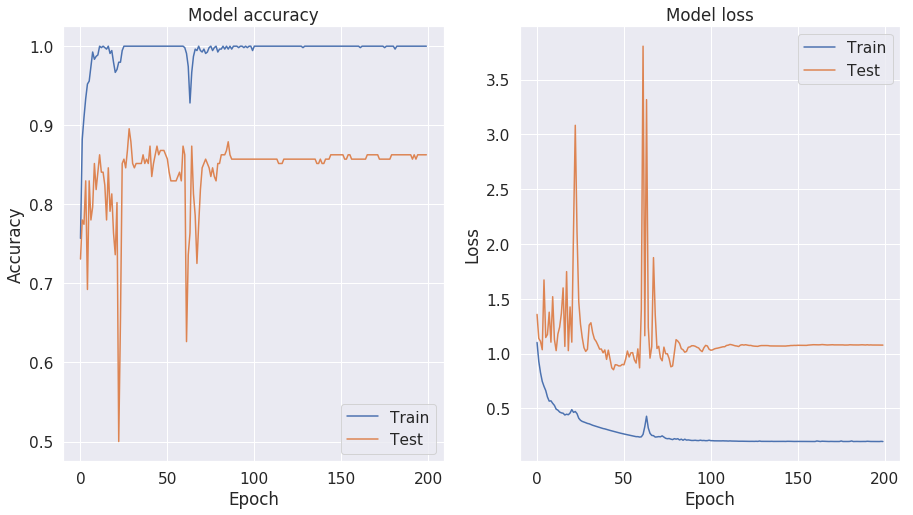

In [34]:
f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 8))

# Plot training & validation accuracy values
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('Model accuracy')
ax1.set(xlabel="Epoch", ylabel="Accuracy")
ax1.legend(['Train', 'Test'], loc='down right')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set(xlabel="Epoch", ylabel="Loss")
ax2.legend(['Train', 'Test'], loc='upper right')

plt.show()

In [11]:
predictions = model.predict(faces)

In [83]:
metrics.log_loss(labels[:,1],predictions[:,1])

nan

In [93]:
np.round(predictions[:,0],2)-labels[:,0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.00999999,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.01999998,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.94      ,  0.        ,  0.        ,  0.        ,
       -0.82      ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.01999998,  0.        ,  0.        ,  0.        ,  0.  

In [92]:
predictions

array([[9.9999833e-01, 1.6527563e-06],
       [9.9999642e-01, 3.5211956e-06],
       [9.9999988e-01, 1.0021100e-07],
       ...,
       [9.9965966e-01, 3.4035344e-04],
       [9.9997306e-01, 2.6966243e-05],
       [9.9994123e-01, 5.8824557e-05]], dtype=float32)